In [1]:
import os
import matplotlib.pyplot as plt
import potion.visualization.notebook_utils as nu

# LQG safe

seeds = [2030, 4473, 5759, 5756, 4146, 1428, 9723, 3212, 8589, 1971]

In [2]:
os.chdir('/home/matteo/policy-optimization/results/lqg_safe')

SEPGMI: -91.724603 +- 0.221551
SEPGBUD: -22.180058 +- 0.362868
ADASTEP: -103.767587 +- 0.206888


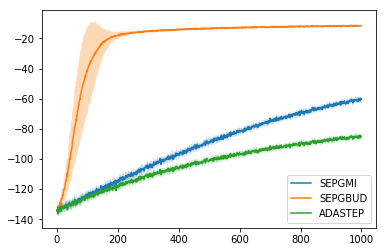

SEPGMI: 0.790785 +- 0.000150
SEPGBUD: 0.129274 +- 0.003451
ADASTEP: 1.000000 +- 0.000000


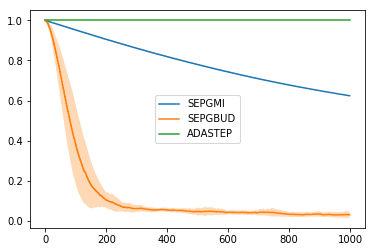

In [3]:
nu.compare('lqgd', 
           ['SEPGMI', 'SEPGBUD', 'ADASTEP'], 
           keys=['UPerf', 'Exploration'], 
           separate=False,
           conf=.99,
           nrows=1000)

In [4]:
nu.save_csv('lqgd', 'SEPGMI', 'UPerf', path='/home/matteo/budget_paper/neurips19/plots', conf=.99, rows=1000)
nu.save_csv('lqgd', 'SEPGBUD', 'UPerf', path='/home/matteo/budget_paper/neurips19/plots', conf=.99, rows=1000)
nu.save_csv('lqgd', 'ADASTEP', 'UPerf', path='/home/matteo/budget_paper/neurips19/plots', conf=.99, rows=1000)
nu.save_csv('lqgd', 'SEPGMI', 'Exploration', path='/home/matteo/budget_paper/neurips19/plots', conf=.99, rows=1000)
nu.save_csv('lqgd', 'SEPGBUD', 'Exploration', path='/home/matteo/budget_paper/neurips19/plots', conf=.99, rows=1000)
nu.save_csv('lqgd', 'ADASTEP', 'Exploration', path='/home/matteo/budget_paper/neurips19/plots', conf=.99, rows=1000)